<h1 style="color:red; text-align:center; text-decoration:underline;">Transfer Learning</h1>


# Apprentissage par transfert simplifié avec l’ensemble de données CIFAR-10

Pour consulter d'autres notebooks tutoriels sur l'apprentissage profond, **https://github.com/tirthajyoti/Deep-learning-with-Python**.

---

## Qu’est-ce que l’apprentissage par transfert ?

**Les réseaux de neurones profonds sont très gourmands en ressources et coûteux en calcul.**
Contrairement aux modèles d’apprentissage statistique traditionnels (comme la régression ou les arbres de décision), ils comportent des millions de paramètres et nécessitent donc de grandes quantités de données pour éviter le surapprentissage.

Ils s’appuient aussi sur des opérations vectorielles massives (comme la multiplication de matrices) pour optimiser les paramètres du modèle. Cela demande une puissance de calcul importante.

Mais une fois un bon modèle formé, ne voudrions-nous pas le réutiliser autant que possible ?

> Mais voici le problème :

**Les algorithmes d’apprentissage profond sont encore conçus pour fonctionner de manière isolée.**
Ils sont généralement entraînés pour résoudre des tâches spécifiques, et doivent souvent être reconstruits dès que les données changent.

**Les humains, eux, savent transférer leurs connaissances entre les tâches.**
Ce qu’on apprend dans un domaine peut souvent être réutilisé ailleurs, surtout s’il y a des similitudes.

> **L'apprentissage par transfert consiste à réutiliser des connaissances apprises pour une tâche, afin d’en résoudre une autre, en particulier dans le contexte de l'apprentissage profond.**

![transfer-learning](https://raw.githubusercontent.com/tirthajyoti/Deep-learning-with-Python/master/images/Transfer_learning.jpeg)

---

## Démonstration de l'apprentissage par transfert avec un exemple simple

### Une stratégie courante

Il existe de nombreuses stratégies pour appliquer l'apprentissage par transfert, selon le type de données, le domaine, s’il s’agit d’un apprentissage supervisé ou non, etc.

Mais pour simplifier, on peut dire qu’il faut :

- Prendre un modèle d’apprentissage profond pré-entraîné,
- Réutiliser tout ou partie de ce modèle,
- L’adapter à un nouveau problème (classification, régression…).

Cela permet d’économiser énormément de calcul.

À la fin, un modèle pré-entraîné est simplement un ensemble de poids. On peut le réutiliser pour d’autres prédictions si les données sont similaires.

Mais comme il a été conçu pour une tâche précise, une stratégie bien connue consiste à :

- Charger les poids d’un modèle pré-entraîné (sauf les dernières couches),
- Garder ces poids fixes, non entraînables,
- Ajouter de nouvelles couches pour la nouvelle tâche,
- Et entraîner le tout sur de nouvelles données.


![TL-DL](https://raw.githubusercontent.com/tirthajyoti/Deep-learning-with-Python/master/images/Transfer-learning-DL-1.png)

## Cette démonstration

Nous illustrons le concept d’apprentissage par transfert dans un cadre très simple.

Nous utilisons l’ensemble de données CIFAR-10 et nous :

- Créons un modèle Keras en empilant des couches de classification sur des couches de caractéristiques.
- L'entraînons sur un sous-ensemble de CIFAR-10 (catégories 0 à 4).
- Gelons les couches de caractéristiques, et ajoutons de nouvelles couches fully-connected.
- Entraînons ce nouveau modèle uniquement sur les catégories 5 à 9.

## Importer les bibliothèques et les fonctions


In [1]:
from __future__ import print_function

from time import time
import keras
from keras.datasets import mnist,cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras import backend as K

import matplotlib.pyplot as plt
import random

## Filtres, taille du pool et taille du noyau


In [2]:
# number of convolutional filters to use
filters = 64
# size of pooling area for max pooling
pool_size = 2
# convolution kernel size
kernel_size = 3

## Charger et diviser les données entre les ensembles d’entraînement et de test


In [3]:
(x_cifar_train, y_cifar_train), (x_cifar_test, y_cifar_test) = cifar10.load_data()

In [4]:
y_cifar_train = y_cifar_train.reshape(50000,)
y_cifar_test = y_cifar_test.reshape(10000,)

## Créer deux ensembles de données : l’un avec des étiquettes de classe inférieures à 5 et l’autre avec 5 et plus


In [5]:
x_train_lt5 = x_cifar_train[y_cifar_train < 5]
y_train_lt5 = y_cifar_train[y_cifar_train < 5]
x_test_lt5 = x_cifar_test[y_cifar_test < 5]
y_test_lt5 = y_cifar_test[y_cifar_test < 5]

x_train_gte5 = x_cifar_train[y_cifar_train >= 5]
y_train_gte5 = y_cifar_train[y_cifar_train >= 5] - 5
x_test_gte5 = x_cifar_test[y_cifar_test >= 5]
y_test_gte5 = y_cifar_test[y_cifar_test >= 5] - 5

### Voyons quelques exemples des deux ensembles de données pour comprendre ce qui se passe.

Voici la description des catégories dans le jeu de données CIFAR-10.


![cifar-10](https://raw.githubusercontent.com/tirthajyoti/Deep-learning-with-Python/master/images/CIFAR-10-categories.PNG)

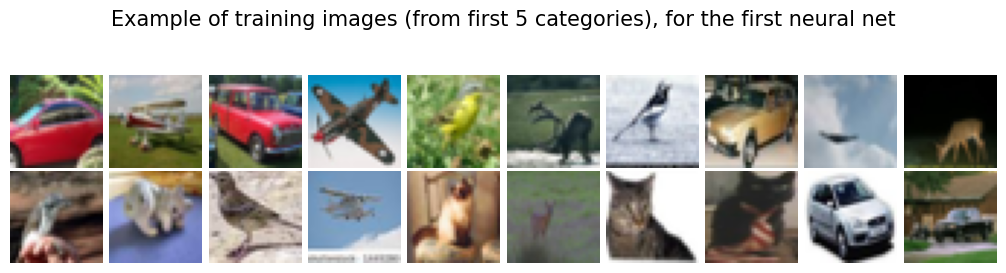

In [6]:
fig, ax = plt.subplots(2,10,figsize=(10,2.8))
fig.suptitle("Example of training images (from first 5 categories), for the first neural net\n", fontsize=15)
axes = ax.ravel()
for i in range(20):
    # Pick a random number
    idx=random.randint(1,1000)
    axes[i].imshow(x_train_lt5[idx])
    axes[i].axis('off')
fig.tight_layout(pad=0.5)
plt.show()

Nous pouvons exécuter la cellule précédente plusieurs fois afin de sélectionner aléatoirement des indices et d’afficher les images correspondantes. Toutefois, étant donné que les images sont extraites du jeu de données `x_train_lt5`, seules les catégories suivantes seront visibles : **avion, automobile, oiseau, chat** ou **cerf**.

C’est donc exclusivement ce type de données que le réseau de neurones initial sera amené à traiter lors de son apprentissage.

En revanche, lors du transfert de l’apprentissage vers un nouveau réseau de neurones, les couches de sortie seront ajustées pour un nouveau jeu de données, composé cette fois d’images correspondant aux catégories suivantes : **chien, grenouille, cheval, mouton** ou **camion**.

Nous verrons néanmoins que le modèle s’adaptera parfaitement à cette nouvelle tâche.


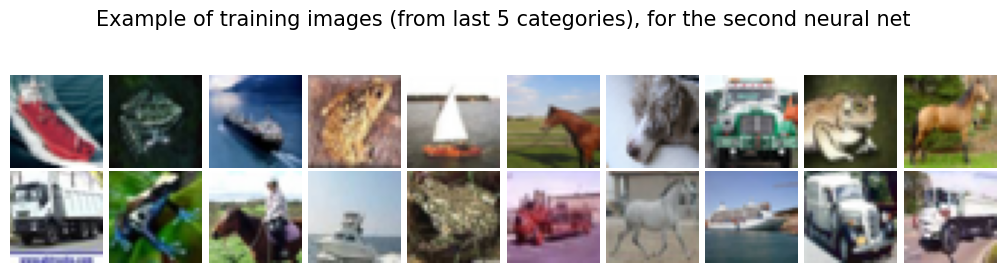

In [7]:
fig, ax = plt.subplots(2,10,figsize=(10,2.8))
fig.suptitle("Example of training images (from last 5 categories), for the second neural net\n", fontsize=15)
axes = ax.ravel()
for i in range(20):
    # Pick a random number
    idx=random.randint(1,1000)
    axes[i].imshow(x_train_gte5[idx])
    axes[i].axis('off')
fig.tight_layout(pad=0.5)
plt.show()

## Définir le nombre de classes et la forme d’entrée


In [8]:
num_classes = 5
input_shape = (32,32,3)

## Définir deux groupes de couches : extraction de caractéristiques (convolutions) et classification (dense)


In [9]:
feature_layers = [
    Conv2D(filters, kernel_size,
           padding='valid',
           input_shape=input_shape),
    Activation('relu'),
    Conv2D(filters, kernel_size),
    Activation('relu'),
    MaxPooling2D(pool_size=pool_size),
    Dropout(0.25),
    Flatten(),
]

C:\Users\Lenovo Thinkpad X1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
classification_layers = [
    Dense(128),
    Activation('relu'),
    Dropout(0.25),
    Dense(num_classes),
    Activation('softmax')
]

## Créer le modèle complet en empilant les couches de caractéristiques (`feature_layers`) et les couches de classification (`classification_layers`)


In [11]:
model_1 = Sequential(feature_layers + classification_layers)

## Définition de la fonction d’entraînement d’un modèle


In [12]:
def train_model(model, train, test, num_classes):
    x_train = train[0].reshape((train[0].shape[0],) + input_shape)
    x_test = test[0].reshape((test[0].shape[0],) + input_shape)
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255

    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    y_train = keras.utils.to_categorical(train[1], num_classes)
    y_test = keras.utils.to_categorical(test[1], num_classes)

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])

    t1 = time()
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test))
    t2 = time()
    print('Training time: {} seconds'.format(round(t2 - t1, 2)))

    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    
    return history


## Taille des lots (batch size) et nombre d’époques (epochs)


In [13]:
batch_size = 128
epochs = 20

## Entraîner le modèle sur les 5 premières catégories d’images


In [14]:
history_1 = train_model(model_1,
                        (x_train_lt5, y_train_lt5),
                        (x_test_lt5, y_test_lt5), num_classes)

x_train shape: (25000, 32, 32, 3)
25000 train samples
5000 test samples
Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 39s 187ms/step - accuracy: 0.4280 - loss: 1.3515 - val_accuracy: 0.6614 - val_loss: 0.8688
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 39s 197ms/step - accuracy: 0.6493 - loss: 0.8799 - val_accuracy: 0.6914 - val_loss: 0.7837
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 39s 197ms/step - accuracy: 0.6863 - loss: 0.7867 - val_accuracy: 0.7096 - val_loss: 0.7328
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 204ms/step - accuracy: 0.7275 - loss: 0.7028 - val_accuracy: 0.7206 - val_loss: 0.7160
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 39s 197ms/step - accuracy: 0.7510 - loss: 0.6409 - val_accuracy: 0.7460 - val_loss: 0.6558
Epoch 6/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 39s 196ms/step - accuracy: 0.7831 - loss: 0.5726 - val_accuracy: 0.7558 - val_loss: 0.6393
Epoch 7/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 203ms/step - accuracy: 0.8019 - loss: 0.5224 - val_accuracy: 0.7624 - val_loss: 0.6352
Epoch 8/20


Notez également que le temps d'entraînement est d’environ 87 secondes. Ce temps peut varier selon les performances de votre matériel, mais il est utile de le noter.


### Afficher le résumé du modèle et noter qu’aucun paramètre n’est non entraînable


In [15]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 5)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,935,377 (18.83 MB)

 Trainable params: 1,645,125 (6.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,290,252 (12.55 MB)

### Évolution de la précision (accuracy) au cours de l’entraînement


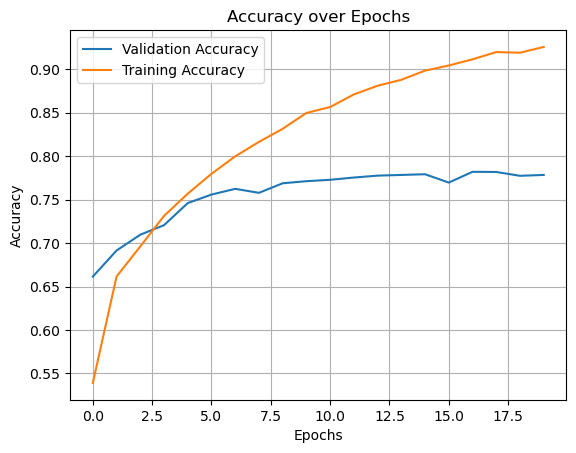

In [16]:
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


## Geler les couches de caractéristiques et reconstruire le modèle

Le gel des couches de caractéristiques est un élément central de l’apprentissage par transfert. Il permet de réutiliser un modèle pré-entraîné pour des tâches de classification, car il suffit d’empiler de nouvelles couches entièrement connectées sur les couches de caractéristiques déjà entraînées pour obtenir de bonnes performances.

Nous allons ici créer un nouveau modèle nommé `model_2`, avec les `feature_layers` gelées (non entraînables) et les `classification_layers` restées entraînables.


In [17]:
for l in feature_layers:
    l.trainable = False

In [18]:
model_2 = Sequential(feature_layers + classification_layers)

### Afficher le résumé du modèle et vérifier que les couches de caractéristiques (Conv2D) sont désormais non entraînables


In [19]:
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 5)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,645,125 (6.28 MB)

 Trainable params: 1,606,405 (6.13 MB)

 Non-trainable params: 38,720 (151.25 KB)

### Entraîner le modèle et observer s’il nécessite moins de temps global tout en maintenant (ou dépassant) les performances précédentes en validation


In [20]:
# transfer: train dense layers for new classification task
train_model(model_2,
            (x_train_gte5, y_train_gte5),
            (x_test_gte5, y_test_gte5), num_classes)

x_train shape: (25000, 32, 32, 3)
25000 train samples
5000 test samples
Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 16s 78ms/step - accuracy: 0.2641 - loss: 2.6425 - val_accuracy: 0.6950 - val_loss: 0.8520
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.6533 - loss: 0.8908 - val_accuracy: 0.7634 - val_loss: 0.6625
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 16s 79ms/step - accuracy: 0.7420 - loss: 0.6857 - val_accuracy: 0.7988 - val_loss: 0.5569
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.7782 - loss: 0.5987 - val_accuracy: 0.8158 - val_loss: 0.5113
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.8100 - loss: 0.5077 - val_accuracy: 0.8262 - val_loss: 0.4900
Epoch 6/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.8302 - loss: 0.4560 - val_accuracy: 0.8352 - val_loss: 0.4769
Epoch 7/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.8455 - loss: 0.4099 - val_accuracy: 0.8402 - val_loss: 0.4694
Epoch 8/20
196/196

Le temps d'entraînement a été considérablement réduit à environ 52 secondes. Cela s'explique par le fait que nous n'avons pas entraîné les couches initiales de type Conv2D, mais uniquement ajusté les couches entièrement connectées. Cependant, la précision obtenue reste très satisfaisante.


## Tracer la courbe de précision


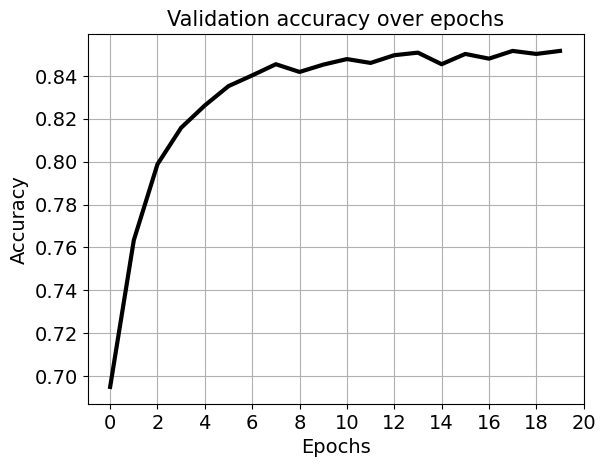

In [23]:
plt.title("Validation accuracy over epochs", fontsize=15)

# Correction : utiliser la bonne clé si 'val_accuracy' est présente
plt.plot(model_2.history.history['val_accuracy'], lw=3, c='k')

plt.grid(True)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.xticks([2*i for i in range(11)], fontsize=14)
plt.yticks(fontsize=14)
plt.show()


## Temps nécessaire pour l’entraînement des deux modèles (nombre d’époques identique)


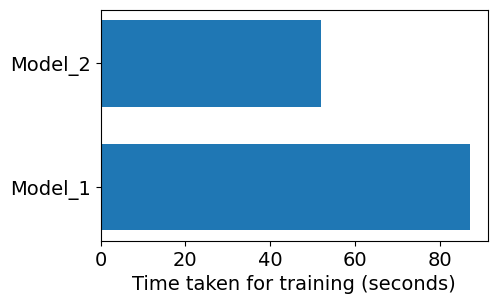

In [24]:
plt.figure(figsize=(5,3))
plt.barh(y=['Model_1','Model_2'],width=[87,52],height=0.7)
plt.xlabel("Time taken for training (seconds)",fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()

## Résumé

Le `model_2` a été initialisé comme un nouveau modèle composé de couches Conv2D non entraînables et de couches entièrement connectées entraînables. Les poids des couches Conv2D ont été transférés depuis un modèle préalablement entraîné, `model_1`.

Non seulement `model_2` s’est entraîné plus rapidement que `model_1`, mais il a également commencé avec une précision de base plus élevée, et a atteint une précision finale supérieure pour le même nombre d’époques et d’hyperparamètres identiques (taux d’apprentissage, optimiseur, taille des lots, etc.).

Et cela a été réalisé en utilisant des images sur lesquelles `model_2` n’a jamais été entraîné auparavant. **C’est précisément cela l’essence de l’apprentissage par transfert.**

Cela signifie que bien que `model_1` ait été entraîné sur des images d’**avion, voiture, oiseau, chat** ou **cerf**, les poids qu’il a appris, une fois transférés à `model_2`, ont permis à ce dernier d’obtenir d’excellentes performances de classification sur des catégories complètement différentes telles que : **chien, grenouille, cheval, mouton** ou **camion**.

![two-categories](https://raw.githubusercontent.com/tirthajyoti/Deep-learning-with-Python/master/images/transfer-learning-2-categories.png)


